<a href="https://colab.research.google.com/github/adnair11/adverserial-robustness-project/blob/main/SRP_First_Presentation_Fashion%20_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#upload model file model.py
from google.colab import files
uploaded = files.upload()

Saving models.py to models.py


In [3]:
#installing all dependencies
!pip install torchattacks
!pip install torch==1.7.1 torchvision==0.8.2 
!pip install torch-dct


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 30.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 10.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.7.1 which is incompatible.
t

In [18]:
#importing all necessary libraries
import torch_dct as dct
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD, FGSM
from torchattacks import FFGSM

from models import CNN
import random
#random.seed(42)

In [27]:
#Downloading Fashion MNIST Dataset
train_list_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=train_list_transforms,
                          download=True)

fashion_mnist_test = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=train_list_transforms,
                         download=True)

In [28]:
#loading the dataset with pytorch loaders
batch_size = 128
import torch
torch.manual_seed(0)

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

In [29]:
#defining model and parameters
model = CNN().cuda()
model1 = CNN().cuda()
model2 = CNN().cuda()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 10
model

CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [22]:
#standard test function showing accuarcy (no attack)
def standard_test(model):
      model.eval()

      correct = 0
      total = 0

      for images, labels in test_loader:
          
          images = images.cuda()
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum()
          
      print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

In [23]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel

def test_attack(model,test_loader,attack="FGSM",dct_test=False):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          

          for images, labels in test_loader:
              
              if(dct_test==False):
                images = atk(images, labels).cuda()
              else:
                img =dct.dct1(images)
                images = atk(img, labels).cuda()
                images=dct.idct(images)

              
              outputs = model(images)
              
              _, predicted = torch.max(outputs.data, 1)
              
              total += labels.size(0)
              correct += (predicted == labels.cuda()).sum()
          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))

In [24]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel
#can also vary the percentage of adversarial examples .Default = 1 (100% attack)

def test_attack_percentage(model,test_loader,attack="FGSM",dct_test=False,percentage = 1):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          
          counter = 0
      

          for images, labels in test_loader:

              images, labels = images.cuda(), labels.cuda()
              
              if(counter < int(len(test_loader)*percentage)):    #int(len(test_loader))):

                if(dct_test==False):
                  images = atk(images, labels).cuda()
                else:
                  img =dct.dct1(images)
                  images = atk(img, labels).cuda()
                  images=dct.idct(images)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()

                counter +=1
              else:

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()
      

          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))
          print(len(test_loader))
          print(counter)

In [25]:
#train function with PGD attack and toggle between DCT and Pixel representation .Default is Pixel

def pgd_train(model,train_loader,optimizer,loss,dct_train=False,num_epochs=5):
    model.train()
    atk = PGD(model, eps=0.3, alpha=0.1, steps=7)
    print(type(atk))
    for epoch in range(num_epochs):

        total_batch = len(fashion_mnist_train) // batch_size
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):

           
            Y = batch_labels.cuda()

            if(dct_train==True):
              dct1 = dct.dct1(batch_images)
              X = atk(dct1, batch_labels).cuda()
              X=dct.idct(X)
            else:
              X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    return cost

In [30]:
#standard training with 0% adversarial examples
def standard_train(model,train_loader,optimizer,loss,num_epochs=5):
  model.train()
  for epoch in range(num_epochs):

      total_batch = len(fashion_mnist_train) // batch_size
      
      for i, (batch_images, batch_labels) in enumerate(train_loader):
          X = batch_images.cuda()
          Y = batch_labels.cuda()

          pre = model(X)
          cost = loss(pre, Y)

          optimizer.zero_grad()
          cost.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

cost0=standard_train(model,train_loader,optimizer,loss)
standard_test(model)

Epoch [1/5], lter [100/468], Loss: 0.7763
Epoch [1/5], lter [200/468], Loss: 0.5712
Epoch [1/5], lter [300/468], Loss: 0.4841
Epoch [1/5], lter [400/468], Loss: 0.4825
Epoch [2/5], lter [100/468], Loss: 0.4182
Epoch [2/5], lter [200/468], Loss: 0.3792
Epoch [2/5], lter [300/468], Loss: 0.2723
Epoch [2/5], lter [400/468], Loss: 0.3267
Epoch [3/5], lter [100/468], Loss: 0.3561
Epoch [3/5], lter [200/468], Loss: 0.2685
Epoch [3/5], lter [300/468], Loss: 0.1833
Epoch [3/5], lter [400/468], Loss: 0.3614
Epoch [4/5], lter [100/468], Loss: 0.3166
Epoch [4/5], lter [200/468], Loss: 0.4844
Epoch [4/5], lter [300/468], Loss: 0.2281
Epoch [4/5], lter [400/468], Loss: 0.1845
Epoch [5/5], lter [100/468], Loss: 0.1737
Epoch [5/5], lter [200/468], Loss: 0.1656
Epoch [5/5], lter [300/468], Loss: 0.2077
Epoch [5/5], lter [400/468], Loss: 0.1391
Standard accuracy: 90.02 %


In [31]:
test_attack(model,test_loader,"FGSM")
test_attack(model,test_loader,"PGD")
test_attack(model,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 42.18 %
TEST with PGD on Fashion MNIST
Robust accuracy : 35.50 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 52.27 %


In [32]:
#Initial training in Pixel representation
cost1=pgd_train(model1,train_loader,optimizer1,loss,num_epochs=10)
cost1

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/10], lter [100/468], Loss: 0.9522
Epoch [1/10], lter [200/468], Loss: 0.8671
Epoch [1/10], lter [300/468], Loss: 0.9051
Epoch [1/10], lter [400/468], Loss: 0.6880
Epoch [2/10], lter [100/468], Loss: 0.7916
Epoch [2/10], lter [200/468], Loss: 0.8382
Epoch [2/10], lter [300/468], Loss: 0.7636
Epoch [2/10], lter [400/468], Loss: 0.6803
Epoch [3/10], lter [100/468], Loss: 0.7395
Epoch [3/10], lter [200/468], Loss: 0.7051
Epoch [3/10], lter [300/468], Loss: 0.7971
Epoch [3/10], lter [400/468], Loss: 0.7240
Epoch [4/10], lter [100/468], Loss: 0.5753
Epoch [4/10], lter [200/468], Loss: 0.6346
Epoch [4/10], lter [300/468], Loss: 0.5793
Epoch [4/10], lter [400/468], Loss: 0.5913
Epoch [5/10], lter [100/468], Loss: 0.5955
Epoch [5/10], lter [200/468], Loss: 0.6686
Epoch [5/10], lter [300/468], Loss: 0.5839
Epoch [5/10], lter [400/468], Loss: 0.5842
Epoch [6/10], lter [100/468], Loss: 0.6928
Epoch [6/10], lter [200/468], Loss: 0.6961
Epoch [6/10], l

tensor(0.7401, device='cuda:0', grad_fn=<NllLossBackward>)

In [33]:
#test accuracy without any attacks
standard_test(model1)

Standard accuracy: 78.36 %


In [34]:
#robustness accuracy after 3 adverserial attacks

test_attack(model1,test_loader,"FGSM")
test_attack(model1,test_loader,"PGD")
test_attack(model1,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 79.02 %
TEST with PGD on Fashion MNIST
Robust accuracy : 76.82 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 83.19 %


In [35]:

test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

/usr/local/lib/python3.7/dist-packages/torch_dct/_dct.py:15: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return torch.rfft(torch.cat([x, x.flip([1])[:, 1:-1]], dim=1), 1)[:, :, 0].view(*x_shape)
/usr/local/lib/python3.7/dist-packages/torch_dct/_dct.py:100: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  v = torch.irfft(V, 1, onesided=False)


TEST with PGD on Fashion MNIST
Robust accuracy : 40.54 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 40.66 %


In [36]:
test_attack_percentage(model1,test_loader,attack="PGD",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FGSM",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FFGSM",dct_test=False,percentage = .5)

TEST with PGD on Fashion MNIST
Robust accuracy : 77.70 %
79
39
TEST with FGSM on Fashion MNIST
Robust accuracy : 78.67 %
79
39
TEST with FFGSM on Fashion MNIST
Robust accuracy : 80.74 %
79
39


In [37]:
#retraining in PGD attack with DCT basis representation

cost2=pgd_train(model1,train_loader,optimizer1,loss,dct_train=True)
cost2

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/5], lter [100/468], Loss: 0.5285
Epoch [1/5], lter [200/468], Loss: 0.3660
Epoch [1/5], lter [300/468], Loss: 0.3968
Epoch [1/5], lter [400/468], Loss: 0.5297
Epoch [2/5], lter [100/468], Loss: 0.3280
Epoch [2/5], lter [200/468], Loss: 0.5533
Epoch [2/5], lter [300/468], Loss: 0.2604
Epoch [2/5], lter [400/468], Loss: 0.3995
Epoch [3/5], lter [100/468], Loss: 0.3602
Epoch [3/5], lter [200/468], Loss: 0.3366
Epoch [3/5], lter [300/468], Loss: 0.4130
Epoch [3/5], lter [400/468], Loss: 0.3907
Epoch [4/5], lter [100/468], Loss: 0.3194
Epoch [4/5], lter [200/468], Loss: 0.5798
Epoch [4/5], lter [300/468], Loss: 0.4197
Epoch [4/5], lter [400/468], Loss: 0.3696
Epoch [5/5], lter [100/468], Loss: 0.1963
Epoch [5/5], lter [200/468], Loss: 0.3790
Epoch [5/5], lter [300/468], Loss: 0.3591
Epoch [5/5], lter [400/468], Loss: 0.3165


tensor(0.2552, device='cuda:0', grad_fn=<NllLossBackward>)

In [38]:
#@title
#testing robustness after attacking in DCT representation 

test_attack(model1,test_loader,"FGSM",True)
test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

TEST with FGSM on Fashion MNIST
Robust accuracy : 86.58 %
TEST with PGD on Fashion MNIST
Robust accuracy : 86.96 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 86.58 %


In [39]:

test_attack(model1,test_loader,"FGSM",False)
test_attack(model1,test_loader,"PGD",False)
test_attack(model1,test_loader,"FFGSM",False)

TEST with FGSM on Fashion MNIST
Robust accuracy : 55.36 %
TEST with PGD on Fashion MNIST
Robust accuracy : 46.51 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 58.42 %


In [40]:
#Loss when converting from Pixel to DCT

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


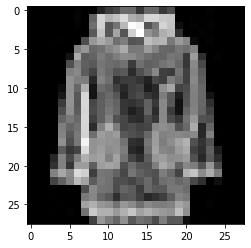

In [ ]:
#Pixel representation
import matplotlib.pyplot as plt

fig = plt.figure()

plt.imshow(example_data[0][0], cmap='gray', interpolation='none')





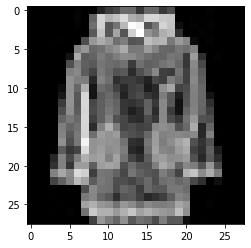

In [ ]:
#DCT representation

fig1 = plt.figure()

plt.imshow(dct.idct(dct.dct(example_data[0][0])), cmap='gray', interpolation='none')



In [ ]:
#MSE LOSS between the two tensors
input = example_data
target = dct.idct(dct.dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(input, target)


#print('input: ', input)
#print('target: ', target)
print('output: ', output)

output:  tensor(2.4476e-15)
